<a href="https://colab.research.google.com/github/njauflo/Blightbuster/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

Fetching data

In [11]:
# Load and preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/potato/train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('/content/drive/My Drive/potato/valid',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 3258 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


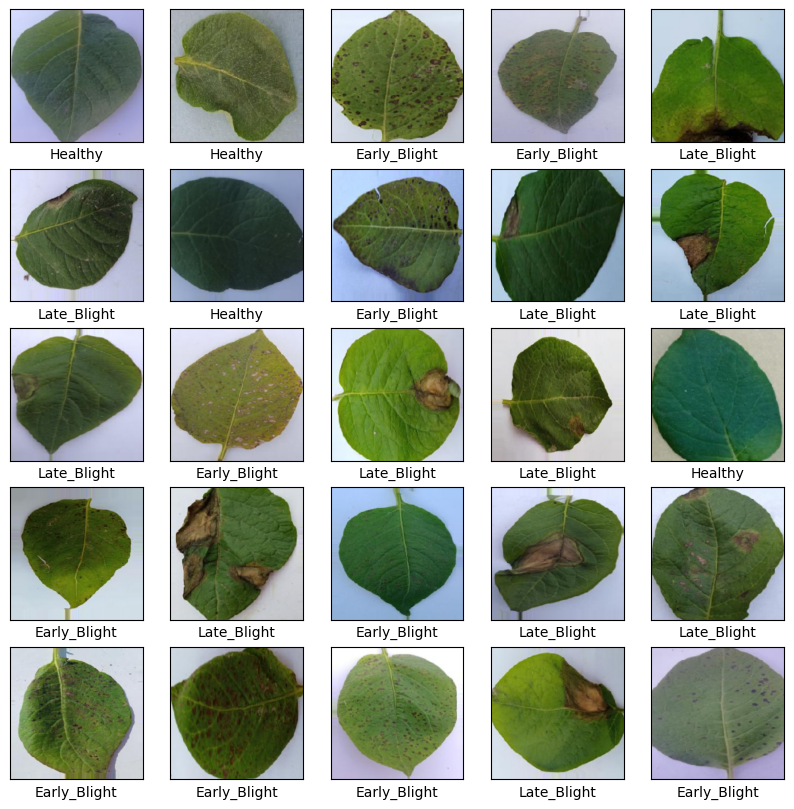

In [12]:
images, labels = next(train_generator)

# Plot the images in the batch along with their corresponding labels
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
plt.show()


In [13]:
# Load a pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classifier layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=validation_generator, epochs=10)

# Save the trained model
model.save('/content/drive/My Drive/model.h5')


Epoch 1/10
102/102 [==============================] - 53s 509ms/step - loss: 0.6431 - accuracy: 0.7281 - val_loss: 0.3847 - val_accuracy: 0.8534
Epoch 2/10
102/102 [==============================] - 52s 512ms/step - loss: 0.3843 - accuracy: 0.8484 - val_loss: 0.3206 - val_accuracy: 0.8750
Epoch 3/10
102/102 [==============================] - 52s 510ms/step - loss: 0.3174 - accuracy: 0.8803 - val_loss: 0.3000 - val_accuracy: 0.8750
Epoch 4/10
102/102 [==============================] - 53s 521ms/step - loss: 0.2958 - accuracy: 0.8880 - val_loss: 0.3326 - val_accuracy: 0.8702
Epoch 5/10
102/102 [==============================] - 51s 503ms/step - loss: 0.2322 - accuracy: 0.9168 - val_loss: 0.2574 - val_accuracy: 0.9038
Epoch 6/10
102/102 [==============================] - 52s 513ms/step - loss: 0.2273 - accuracy: 0.9180 - val_loss: 0.2646 - val_accuracy: 0.8990
Epoch 7/10
102/102 [==============================] - 53s 521ms/step - loss: 0.2142 - accuracy: 0.9217 - val_loss: 0.4057 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Load the test data
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/potato/test',
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

Found 405 images belonging to 3 classes.
13/13 [==============================] - 2s 118ms/step
              precision    recall  f1-score   support

Early_Blight       0.99      0.76      0.86       162
     Healthy       0.72      0.98      0.83       102
 Late_Blight       0.87      0.89      0.88       141

    accuracy                           0.86       405
   macro avg       0.86      0.88      0.86       405
weighted avg       0.88      0.86      0.86       405



[[123  23  16]
 [  0 100   2]
 [  1  15 125]]


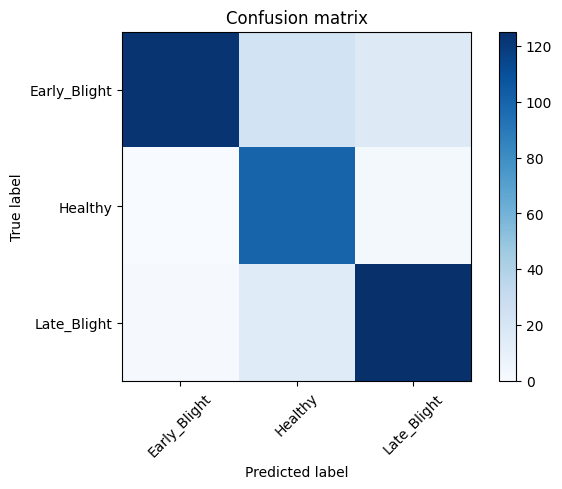

In [15]:
# Print a confusion matrix
print(confusion_matrix(test_generator.classes, predicted_classes))

cm = confusion_matrix(test_generator.classes, predicted_classes)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
